<a href="https://colab.research.google.com/github/sharaddobariya05/HSI-classification-/blob/master/HSI_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd '/content/gdrive/My Drive/hsi/data'

/content/gdrive/My Drive/hsi/data


In [4]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


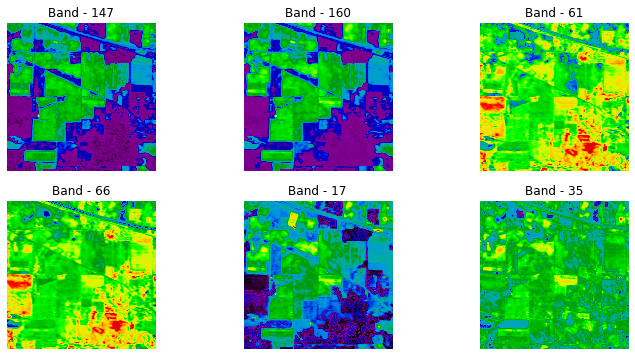

In [5]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

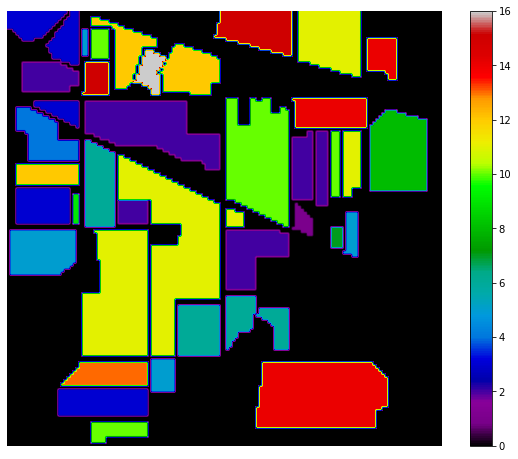

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

In [7]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


In [8]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band162,band163,band164,band165,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [9]:
df.iloc[:, :-1].describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band161,band162,band163,band164,band165,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200
count,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,...,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000
mean,2957.363472,4091.321237,4277.502259,4169.956671,4516.678668,4790.595149,4848.317574,4714.732509,4668.904828,4439.065541,4407.192580,4307.541831,4148.396671,4400.474625,4470.958811,4447.711106,4286.070059,4070.359239,3967.324899,3861.227491,3833.674863,3810.350773,3742.210131,3657.676243,3651.536837,3562.264067,3453.274340,3489.048133,3465.970036,3250.786064,3504.638906,3224.430059,3511.536457,3948.562235,4173.646468,4445.024209,5309.742592,5950.961427,5937.520761,4137.620214,...,1254.995719,1253.893698,1253.598954,1254.374792,1249.088989,1234.321950,1228.068966,1226.639191,1223.088181,1217.272818,1211.462497,1222.972699,1221.611510,1211.583353,1199.533841,1184.804328,1174.728704,1166.305161,1161.820975,1149.567562,1148.084661,1143.412224,1132.359049,1131.622354,1112.867729,1103.281665,1105.472010,1088.798526,1080.433864,1080.911772,1079.310773,1061.927848,1060.210273,1063.276813,1050.048514,1040.201141,1043.370321,1030.194816,1015.571463,1008.513579
std,354.918708,230.390005,257.827640,280.761254,346.035984,414.382138,469.247667,491.728349,533.232855,539.908195,596.191887,674.239859,758.736727,641.221504,634.474623,669.627965,780.740920,852.027946,851.726987,862.120047,876.971776,903.453740,913.732735,917.458683,948.550739,964.297455,957.530392,1019.462914,1033.900906,921.367065,888.806543,909.962902,897.964022,853.073211,654.626044,401.402675,507.061364,720.970575,807.181782,644.574920,...,143.890827,141.264146,139.622976,139.345592,135.489840,126.123887,121.220250,118.651873,116.213130,110.927274,107.742597,112.155944,113.404495,108.799962,104.094061,96.958495,94.966743,92.167377,90.488063,85.149059,85.052178,84.259071,77.447304,77.209432,68.365788,63.499265,63.683355,54.247073,49.002958,50.557675,49.943791,38.843805,38.712195,41.920969,34.242725,26.452672,29.794418,20.865106,11.386402,7.050921
min,2560.000000,2709.000000,3649.000000,2810.000000,3840.000000,4056.000000,4004.000000,3865.000000,3775.000000,2792.000000,2700.000000,2594.000000,2560.000000,2600.000000,2665.000000,2614.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2521.000000,2452.000000,2398.000000,2289.000000,2211.000000,2178.000000,2139.000000,2054.000000,2272.000000,2013.000000,2165.000000,2364.000000,2359.000000,2400.000000,2588.000000,2723.000000,2675.000000,2127.000000,...,1026.000000,1024.000000,1029.0000

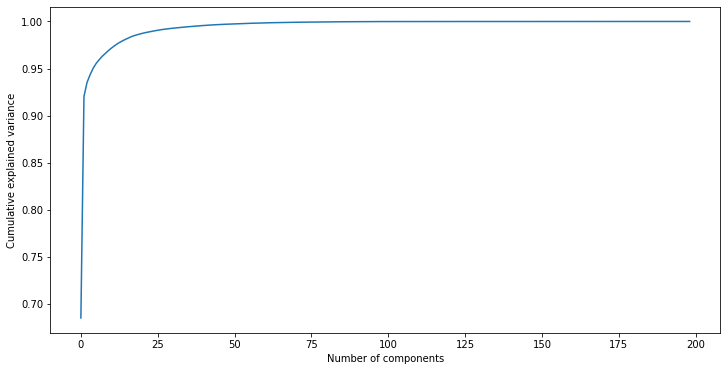

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 199)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


In [11]:
pca = PCA(n_components = 71)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,72)]+['class']

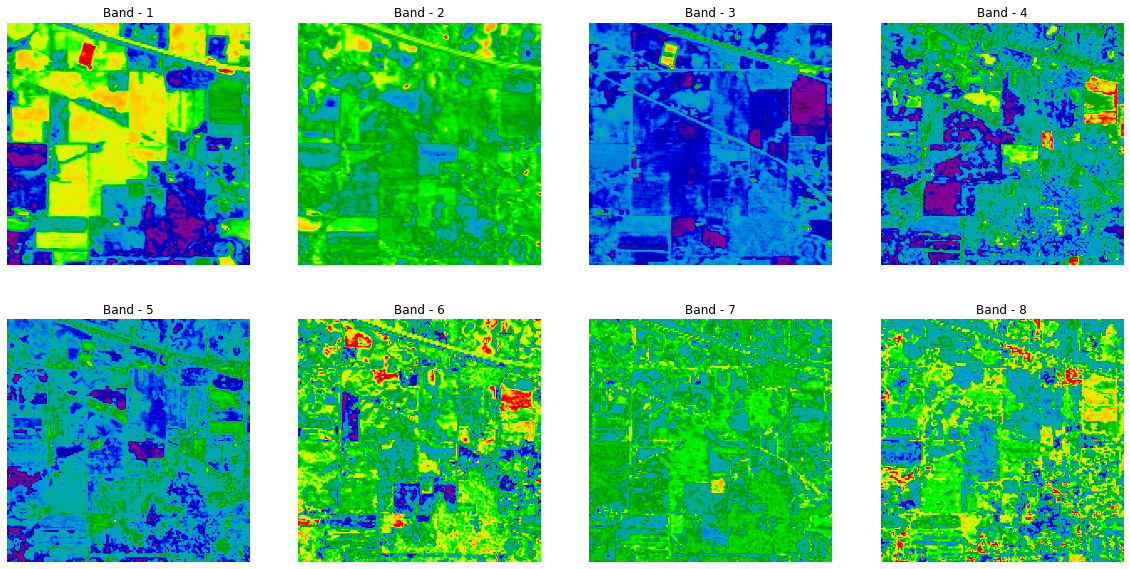

In [12]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('IP_PCA_Bands.png')

In [13]:
# saving to .csv
q.to_csv('IP_71_PCA.csv', index=False)

In [14]:

x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

svm =  SVC(C = 105, kernel = 'rbf', cache_size = 10*1024)

svm.fit(X_train, y_train)

ypred = svm.predict(X_test)

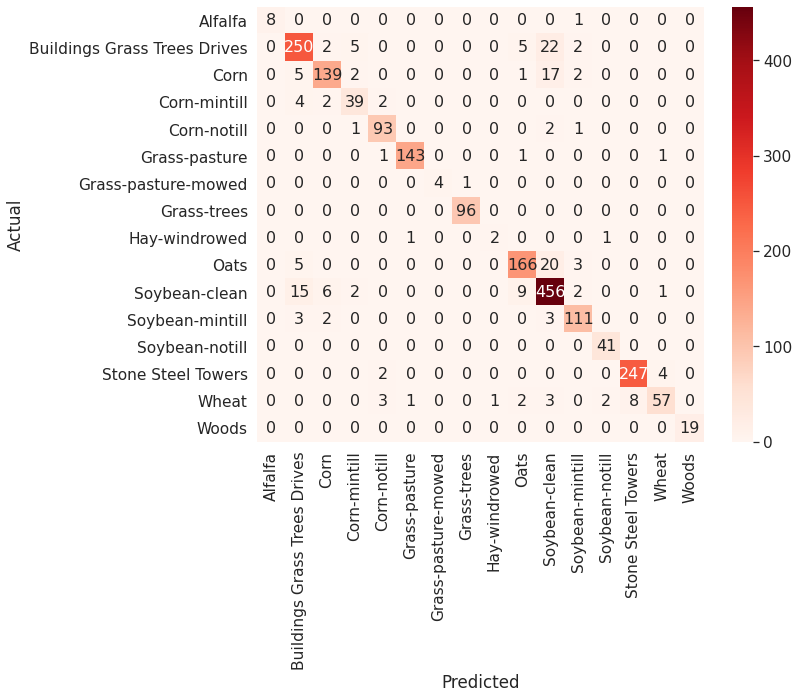

In [15]:
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [16]:
print(classification_report(y_test, ypred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.89      0.87      0.88       286
                Corn-mintill       0.92      0.84      0.88       166
                        Corn       0.80      0.83      0.81        47
               Grass-pasture       0.92      0.96      0.94        97
                 Grass-trees       0.99      0.98      0.98       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.67      0.50      0.57         4
              Soybean-notill       0.90      0.86      0.88       194
             Soybean-mintill       0.87      0.93      0.90       491
               Soybean-clean       0.91      0.93      0.92       119
                       Wheat       0.93      1.00      0.96        41
                   

In [17]:
l=[]
for i in range(q.shape[0]):
  if q.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(svm.predict(q.iloc[i, :-1].values.reshape(1, -1)))

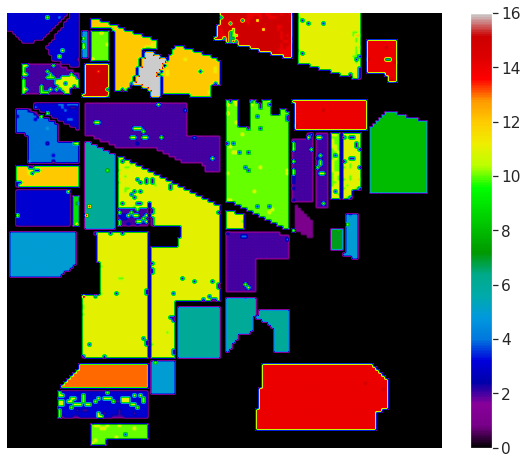

In [18]:
clmap = np.array(l).reshape(145, 145).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()